# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [19]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, desc, min, max, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StringIndexerModel, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


In [20]:
# create a Spark session locally

spark = SparkSession.builder \
    .master('local') \
    .appName('Churn Prediction') \
    .getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [21]:
event_data = 'mini_sparkify_event_data.json'

In [22]:
df = spark.read.json(event_data)

In [23]:
# Inspect the data 
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [24]:
# Inspect the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [25]:
# Find a total number of rows
df.count()

286500

In [26]:
# Find the statistics
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [27]:
# Look atcounts of each column
df.describe().show(1, vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 286500 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 286500 
 lastName      | 278154 
 length        | 228108 
 level         | 286500 
 location      | 278154 
 method        | 286500 
 page          | 286500 
 registration  | 278154 
 sessionId     | 286500 
 song          | 228108 
 status        | 286500 
 ts            | 286500 
 userAgent     | 278154 
 userId        | 286500 
only showing top 1 row



In [28]:
# Inspect unique available userIds
df.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [29]:
df.select('userId').groupby(df.userId).count().sort('userId').show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
|100004| 1245|
|100005|  216|
|100006|   44|
|100007|  520|
|100008|  940|
|100009|  671|
|100010|  381|
|100011|   23|
|100012|  600|
|100013| 1392|
|100014|  310|
|100015| 1050|
|100016|  638|
|100017|   75|
+------+-----+
only showing top 20 rows



In [30]:
# Drop missing values in the userId columns
df_valid = df.filter(df.userId != '')

In [31]:
# Inspect the counts of each column again
df_valid.describe().show(1, vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 278154 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 278154 
 lastName      | 278154 
 length        | 228108 
 level         | 278154 
 location      | 278154 
 method        | 278154 
 page          | 278154 
 registration  | 278154 
 sessionId     | 278154 
 song          | 228108 
 status        | 278154 
 ts            | 278154 
 userAgent     | 278154 
 userId        | 278154 
only showing top 1 row



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [32]:
# Create a udf function to identify churn by flagging an event 
# with the "Cancellation Confirmation" page

is_churned = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())


In [33]:
# Add a new column 'isChurned' by passing a value in the 'page' column to the udf function
# created above (is_churned)
df_valid = df_valid.withColumn('isChurned', is_churned("page"))

In [34]:
# Then, inspect the data
df_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', isChurned=0)

In [35]:
# Then, Identify events of users who are churned by 
# 1. Create a window object partitioned by a userId, ordered descendingly by a timestamp 'ts'
# 2. Then, utilize the pyspark.sql.functions.sum function (Fsum) to perform an accumulate sum
# within a window and assign its value to a new column 'willBeChurned'
# 3. With the steps above, events with users who are churned 

windowval = Window.partitionBy("userId") \
                .orderBy(desc("ts")) \
                .rangeBetween(Window.unboundedPreceding, 0)

df_valid = df_valid.withColumn("willBeChurned", Fsum("isChurned").over(windowval))


In [36]:
# Create a datetime to help with the analysis
get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_valid = df_valid.withColumn('datetime', get_datetime(df_valid.ts))


In [37]:
# Inspect the value
df_valid.filter('willBeChurned == 1') \
    .select('userId', 'datetime', 'page', 'level', 'willBeChurned') \
    .show()

+------+-------------------+--------------------+-----+-------------+
|userId|           datetime|                page|level|willBeChurned|
+------+-------------------+--------------------+-----+-------------+
|   125|2018-10-12 00:35:18|              Cancel| free|            1|
|   125|2018-10-12 00:35:18|Cancellation Conf...| free|            1|
|   125|2018-10-12 00:35:17|         Roll Advert| free|            1|
|   125|2018-10-12 00:35:06|            NextSong| free|            1|
|   125|2018-10-12 00:32:08|            NextSong| free|            1|
|   125|2018-10-12 00:28:35|            NextSong| free|            1|
|   125|2018-10-12 00:22:04|            NextSong| free|            1|
|   125|2018-10-12 00:18:34|            NextSong| free|            1|
|   125|2018-10-12 00:15:11|            NextSong| free|            1|
|   125|2018-10-12 00:11:21|            NextSong| free|            1|
|   125|2018-10-12 00:05:44|            NextSong| free|            1|
|    51|2018-10-17 0

### Compare page counts of events with and without churns

The comparison plot between a percentage of each page for churned and not churned users below shows that the page of most events are 'NextPage' and the plot does not show much difference for each page type

In [38]:
# Get page count of events with and without churns
df_churn_page = df_valid.groupby('willBeChurned', 'page') \
    .count() \
    .orderBy(desc('willBeChurned'), desc('count'))

In [39]:
# And inspect the raw data
df_churn_page.show(50)

+-------------+--------------------+------+
|willBeChurned|                page| count|
+-------------+--------------------+------+
|            1|            NextSong| 36394|
|            1|           Thumbs Up|  1859|
|            1|                Home|  1672|
|            1|     Add to Playlist|  1038|
|            1|         Roll Advert|   967|
|            1|          Add Friend|   636|
|            1|              Logout|   553|
|            1|         Thumbs Down|   496|
|            1|           Downgrade|   337|
|            1|            Settings|   270|
|            1|                Help|   239|
|            1|             Upgrade|   112|
|            1|       Save Settings|    58|
|            1|               About|    56|
|            1|              Cancel|    52|
|            1|Cancellation Conf...|    52|
|            1|      Submit Upgrade|    32|
|            1|               Error|    32|
|            1|    Submit Downgrade|     9|
|            0|            NextS

In [40]:
# Visualize the results by converting data to pandas first
pd_churn_page = df_churn_page.toPandas()

In [41]:
# Then, find a total counts of each type
total_churn_page = pd_churn_page.groupby('willBeChurned')['count'].sum()
total_churn_page

willBeChurned
0    233290
1     44864
Name: count, dtype: int64

In [42]:
# Then, create a new column called 'percentage' to store a percentage number of each page count
def get_page_count_percentage(row):
    return (row['count'] / total_churn_page[row['willBeChurned']])*100

pd_churn_page['percentage'] = pd_churn_page.apply(lambda row: get_page_count_percentage(row), axis=1)

In [43]:
# Show a pivot table to better visualize the data
pd_churn_page.pivot(index='willBeChurned', columns='page', values='percentage')


page,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
willBeChurned,,,,,,,,,,,,,,,,,,,
0,0.188178,1.560718,2.352437,NaN,NaN,0.736422,0.094303,0.520811,3.604955,1.145784,82.178405,1.271379,0.10802,0.533242,0.023147,0.054439,0.878735,4.583137,0.165888
1,0.124822,1.417618,2.313659,0.115906,0.115906,0.751159,0.071327,0.532721,3.726819,1.232614,81.120720,2.155403,0.12928,0.601819,0.020061,0.071327,1.105563,4.143634,0.249643


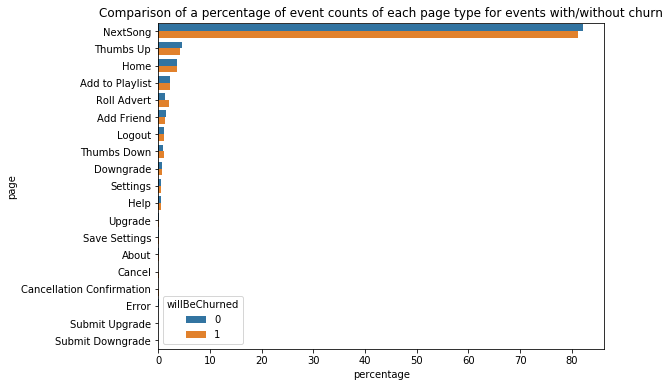

In [44]:
# Finally, use the newly created pandas data frame to create a comparison plot
# to show a difference between a percentage of each page type by churn
plt.figure(figsize=(8,6))

sns.barplot(x='percentage', y='page', hue='willBeChurned', data=pd_churn_page);
plt.title("Comparison of a percentage of event counts of each page type for events with/without churn");

### Inspect a number of songs played in each hour

The plot below shows a similar trend between a number of songs played in each hour of events of users who are/are not churned

In [45]:
# Creat an hour column by calculating Static hour using the 'ts' column
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_valid = df_valid.withColumn('hour', get_hour('ts'))

In [46]:
def plot_NumberOfSongsInHour(willBeChurned):
    '''
    Plot a number of songs in hour for events with the specified willBeChurned value
    '''
    
    # Get a number of songs in hour for a particular data set
    songs_in_hour = df_valid.filter(df_valid.willBeChurned == willBeChurned) \
        .groupby('hour') \
        .count() \
        .orderBy(df_valid.hour.cast("float"))

    
    # Convert to pandas and create a scatter plot

    pd_songs_in_hour = songs_in_hour.toPandas()
    pd_songs_in_hour.hour = pd.to_numeric(pd_songs_in_hour.hour)

    plt.scatter(pd_songs_in_hour["hour"], pd_songs_in_hour["count"]);
    plt.xlim(-1, 24);
    plt.ylim(0, 1.2 * pd_songs_in_hour["count"].max())
    plt.xlabel("Hour")
    plt.ylabel("Songs played");

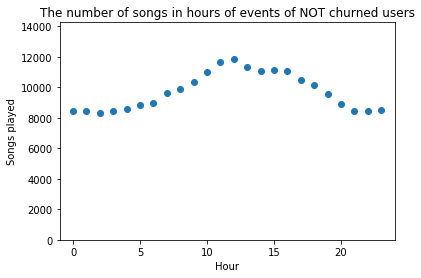

In [47]:
# Create a scatter plot to inspect The number of songs in hours of events of not churned users
plot_NumberOfSongsInHour(0)
plt.title('The number of songs in hours of events of NOT churned users');

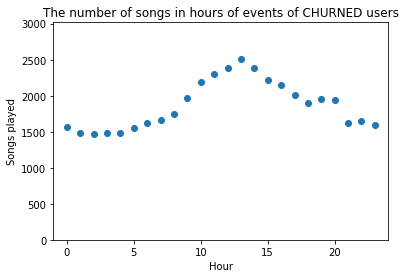

In [48]:
# Create a scatter plot to inspect The number of songs in hours of events of not churned users
plot_NumberOfSongsInHour(1)
plt.title('The number of songs in hours of events of CHURNED users');

### Inspect a ratio of each gender

The data below shows that it is more likely for Male to be churned than a female

In [49]:
df_gender = df_valid.select("userId", "gender", 'willBeChurned') \
    .dropDuplicates() \
    .groupby('willBeChurned', 'gender') \
    .count() 

In [50]:
df_gender.orderBy('willBeChurned', 'gender').show()

+-------------+------+-----+
|willBeChurned|gender|count|
+-------------+------+-----+
|            0|     F|   84|
|            0|     M|   89|
|            1|     F|   20|
|            1|     M|   32|
+-------------+------+-----+



In [51]:
pd_gender = df_gender.toPandas()

In [52]:
pd_gender_pivot = pd_gender.pivot(index='willBeChurned', columns='gender', values='count')
total_counts = pd_gender_pivot.sum(axis=1)
pd_gender_pivot = pd_gender_pivot.div(total_counts, axis=0)
pd_gender_pivot

gender,F,M
willBeChurned,,
0,0.485549,0.514451
1,0.384615,0.615385


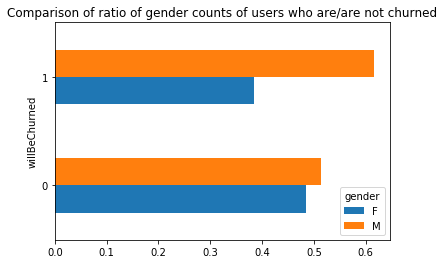

In [53]:
pd_gender_pivot.plot.barh();
plt.title('Comparison of ratio of gender counts of users who are/are not churned');

### Inspect session time

The statistics of session time below shows that 
* The average of session time of users who are churned is around 283 minutes/session 
* The the average of session time of users who are NOT  churned is around 302 minutes/session

In [56]:
# Filter data based on its willBeChurned status first 
df_churn = df_valid.filter('willBeChurned == 1')
df_not_churn = df_valid.filter('willBeChurned == 0')

In [57]:
def get_session_time(df, showSummary=False):
    '''
    Get a number of registration days of the given data
    
    Input Argument:
        df:   Sparkify dataframe
        
    Optional Input Argument:
        showSummary: Show summary statistics of the output data fram. Default is False.
        
    Output Argument:
        df_sessionTime: Spark dataframe contains sessionTime information of each userId and sessionId
    '''
    
    # Find a session time by grouping events by userId and sessionId
    # and then find a difference between the min and max timestamp
    df_sessionTime = df.groupby("userId", "sessionId") \
        .agg(((max(df.ts)-min(df.ts))/(1000*60)) \
        .alias("sessionTime"))
    
    if showSummary:
        # Print the statistics
        df_sessionTime.select('sessionTime').describe().show();

        # Create a box plot
        df_sessionTime.select('sessionTime').toPandas().boxplot();
    
    return df_sessionTime;
    

+-------+------------------+
|summary|       sessionTime|
+-------+------------------+
|  count|               537|
|   mean|283.12153941651144|
| stddev| 375.3192516301637|
|    min|               0.0|
|    max| 3300.016666666667|
+-------+------------------+



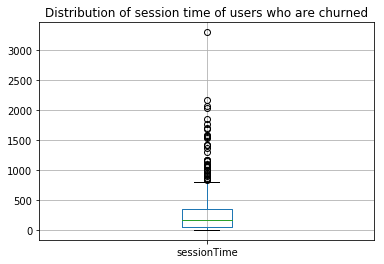

In [58]:
df_sessionTime_churn = get_session_time(df_churn, showSummary=True)
plt.title('Distribution of session time of users who are churned');

+-------+------------------+
|summary|       sessionTime|
+-------+------------------+
|  count|              2639|
|   mean|302.85536187949987|
| stddev| 393.2417448405121|
|    min|               0.0|
|    max| 4455.083333333333|
+-------+------------------+



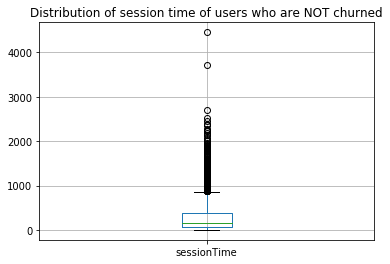

In [59]:
df_sessionTime_not_churn = get_session_time(df_not_churn, showSummary=True)
plt.title('Distribution of session time of users who are NOT churned');

### Inspect a number of songs per session

The statistics of session time below shows that 
* The average of songs played in each session of users who are churned is around 70 songs
* The average of songs played in each session of users who are NOT churned is around 75 songs

In [60]:
def get_songs_per_session(df, showSummary=False):
    '''
    Get a number of songs played in each userId and sessionId
    
    Input Argument:
        df:   Sparkify dataframe
        
    Optional Input Argument:
        showSummary: Show summary statistics of the output data fram. Default is False.
        
    Output Argument:
        df_songs_per_session: Spark dataframe contains information of each userId and sessionId
    '''
    
    # Filter only events with the "NextSong" page
    # Then, group them by userId and sessionId and find the counts
    df_songs_per_session = df.filter(df.page=="NextSong") \
        .groupby("userId", "sessionId") \
        .count()
    
    if showSummary:
        # Print the statistics
        df_songs_per_session.select('count').describe().show();

        # Create a box plot
        df_songs_per_session.select('count').toPandas().boxplot();
    
    return df_songs_per_session;



+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|              519|
|   mean| 70.1233140655106|
| stddev|88.76147060464491|
|    min|                1|
|    max|              708|
+-------+-----------------+



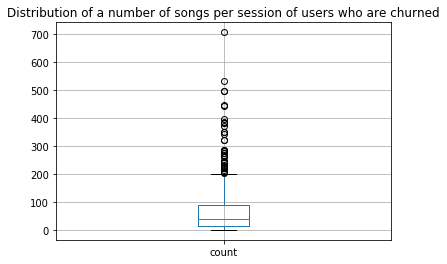

In [61]:
df_songs_per_session_churn = get_songs_per_session(df_churn, showSummary=True);
plt.title('Distribution of a number of songs per session of users who are churned');

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|             2552|
|   mean| 75.1230407523511|
| stddev|94.27929882985644|
|    min|                1|
|    max|             1093|
+-------+-----------------+



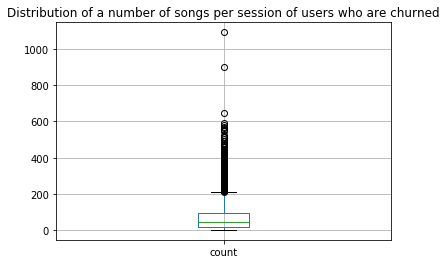

In [62]:
df_songs_per_session_not_churn = get_songs_per_session(df_not_churn, showSummary=True)
plt.title('Distribution of a number of songs per session of users who are churned');

### Inspect a number of registration days

The data below shows that a number of registration days of users who are churned are around 57 days

In [63]:
def get_user_reg_days(df, showSummary=False):
    '''
    Get a number of registration days of the given data
    
    Input Argument:
        df:   Sparkify dataframe
        
    Optional Input Argument:
        showSummary: Show summary statistics of the output data fram. Default is False.
        
    Output Argument:
        user_reg_days: Spark dataframe contains information of a number of registration days
    '''
    
    # Get a max timestamp of each ID first
    user_max_ts = df.groupby("userId").max("ts").sort("userId")

    # Get the registration timestamp. We only need to get it from the first data 
    # since they will all be the same
    user_reg_ts = df.select("userId", "registration").dropDuplicates().sort("userId")

    # Join the max timestamp and registration timestamp table
    join_reg_max_ts = user_reg_ts.join(user_max_ts, (user_reg_ts.userId == user_max_ts.userId))

    # Then, select
    # 1) The userId column
    # 2) Computed a number of registration days from the max and registration columns
    user_reg_days = join_reg_max_ts.select(user_reg_ts["userId"], 
                                           ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24))
                                            .alias("NumRegDays"))
    
    if showSummary:
        # Print the statistics
        user_reg_days.select('NumRegDays').describe().show();

        # Create a boxplot of the statistics
        user_reg_days.select('NumRegDays').toPandas().boxplot();

    return user_reg_days

+-------+-----------------+
|summary|       NumRegDays|
+-------+-----------------+
|  count|               52|
|   mean|57.30599292200857|
| stddev| 36.6331481313374|
|    min|5.165115740740741|
|    max|188.3117824074074|
+-------+-----------------+



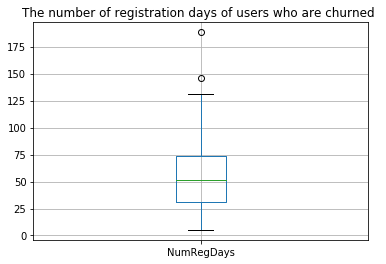

In [64]:
# Get a number of registration days and statistics of users who are churned
user_reg_days = get_user_reg_days(df_churn, showSummary=True)
plt.title('The number of registration days of users who are churned ');

+-------+-------------------+
|summary|         NumRegDays|
+-------+-------------------+
|  count|                173|
|   mean|  86.62061938021833|
| stddev|  35.34864197873643|
|    min|0.31372685185185184|
|    max|  256.3776736111111|
+-------+-------------------+



Text(0.5, 1.0, 'The number of registration days of users who are churned ')

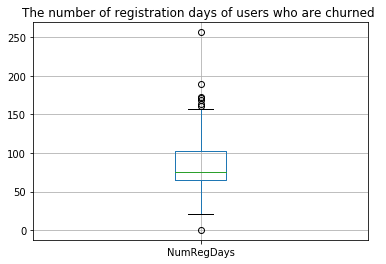

In [65]:
# Get a number of registration days and statistics of users who are NOT churned
user_reg_days = get_user_reg_days(df_not_churn, showSummary=True)
plt.title('The number of registration days of users who are churned ')

### Inspect the last level

The data below shows that a ratio of free/paid users who are/are not churned are similar (around 55/45)

In [66]:
def get_user_level(df, showSummary=False):
    '''
    Get data of the last user level (paid/free) of a given data
    
    Input Argument:
        df:   Sparkify dataframe
    
    Optional Input Argument:
        showSummary: Show summary statistics of the output data fram. Default is False.
        
    Output Argument:
        user_reg_days: Spark dataframe contains data of the last user level (paid/free) of a given data
    '''
    
    # Get a max timestamp of each ID first
    user_max_ts = df.groupby("userId").max("ts").sort("userId")

    # Get the registration timestamp. We only need to get it from the first data 
    # since they will all be the same
    user_level = df.select("userId", "level").dropDuplicates()
    
    
    if showSummary:
        # we will show a summary of counts grouped by 'level' here
        total_user_level = user_level.count()

        group_level = user_level.groupby('level').count()
        get_ratio = udf(lambda x: x*1.0/total_user_level, FloatType())
        df_level = group_level.withColumn('ratio', get_ratio("count"))
        df_level.show()
    
    return user_level;

In [67]:
# Get a number of last level of users who are churned
get_user_level(df_churn, showSummary=True)

+-----+-----+---------+
|level|count|    ratio|
+-----+-----+---------+
| free|   46|0.5609756|
| paid|   36|0.4390244|
+-----+-----+---------+



DataFrame[userId: string, level: string]

In [68]:
# Get a number of last level of users who are NOT churned
get_user_level(df_not_churn, showSummary=True)

+-----+-----+----------+
|level|count|     ratio|
+-----+-----+----------+
| free|  149| 0.5359712|
| paid|  129|0.46402878|
+-----+-----+----------+



DataFrame[userId: string, level: string]

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Based on the Exploratory Data Analysis (EDA) above, we will use the following information to create features that will be used to train our model:
* Gender of the user
* Average session time of each user
* Average number of songs played in each session of each user
* How long the user has been registered
* The last level (paid/free)

**Gender of the user**


In [69]:
# Drop duplicate first because the gender information will not be changed
df_gender = df_valid.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])

# Then, use StringIndexerModel to create an index for gender

fromlabelsModel = StringIndexerModel.from_labels(["F", "M"], \
    inputCol="gender", outputCol="gender_index", handleInvalid="error")
df_gender = fromlabelsModel.transform(df_gender)

# Only extracted interested columns
df_gender = df_gender.select('userId', df_gender.gender_index.cast("int"))
df_gender.head()

Row(userId='10', gender_index=1)

**Average session time of each user**


In [70]:
def scale_column_with_StandardScaler(df, column_name):
    '''
    Scale the specified column name with the StandardScaler
    
    Input arguments:
        df:           Spark dataframe
        column_name:  Column name with numerical value to be scaled with the StandardScaler
    
    Output argument:
        df_scaled:    New Spark dataframe with the "<column_name>_vec" and "<column_name>_scaled" columns
    '''
    
    # Create a vector of sessionTime first before scaling it
    column_vec = column_name + '_vec'
    assembler = VectorAssembler(inputCols=[column_name], outputCol=column_vec)
    df_scaled = assembler.transform(df)

    # Use the StandardScale to scale the session time
    column_scaled = column_name + '_scaled'
    scaler = StandardScaler(inputCol=column_vec, 
                            outputCol=column_scaled, 
                            withStd=True)

    # Then, select only the interested columns
    df_scaled = scaler.fit(df_scaled).transform(df_scaled)
    
    return df_scaled;
    

In [71]:
def get_avg_column_by_user(df, column_name):
    '''
    Get average values of a particular column grouped by userId
    
    Input argument:
    df :  Sparkify dataframe
    column_name: The interested column name that we want to get average values for
    
    Output argument:
    df_avg: Spark dataframe with average values information stored in a column "avg_<column_name>""
    '''
    df_avg = df.groupby('userId') \
                .agg(avg(column_name)) \
                .select('userId', col('avg(' + column_name + ')').alias('avg_' + column_name))
    
    return df_avg
    

In [72]:
# Find the average session time first
df_sessionTime = get_session_time(df_valid)
df_sessionTime_avg = get_avg_column_by_user(df_sessionTime, 'sessionTime')


In [73]:
# Inspect the results
df_sessionTime_avg.show(5)

+------+------------------+
|userId|   avg_sessionTime|
+------+------------------+
|100010|154.48333333333332|
|200002|266.40000000000003|
|   125|29.566666666666666|
|    51| 872.3566666666666|
|   124| 578.9942528735633|
+------+------------------+
only showing top 5 rows



In [74]:
# Then, scaled it
df_sessionTime_avg_scaled = scale_column_with_StandardScaler(df_sessionTime_avg, 'avg_sessionTime')
df_sessionTime_avg_scaled = df_sessionTime_avg_scaled.select('userId', 'avg_sessionTime_scaled')


In [75]:
# Inspect the result
df_sessionTime_avg_scaled.show(5)

+------+----------------------+
|userId|avg_sessionTime_scaled|
+------+----------------------+
|100010|  [0.8735647913871121]|
|200002|   [1.506425679742324]|
|   125|  [0.16719213938081...|
|    51|   [4.932959776880935]|
|   124|   [3.274068359429266]|
+------+----------------------+
only showing top 5 rows



**Average number of songs played in each session of each user**

In [76]:
# Get data of a number of songs per session
df_song = get_songs_per_session(df_valid)

In [77]:
# Get an average number of songs per session of each userId
df_song_avg = get_avg_column_by_user(df_song, 'count')
# Rename the column to be more specific
df_song_avg = df_song.select('userId', col('count').alias('num_songs'))

In [78]:
# Then, scale data in the 'num_songs' column with the StandardScaler
df_song_avg_scaled = scale_column_with_StandardScaler(df_song_avg, 'num_songs')

# And only select the userId and the scaled column
df_song_avg_scaled = df_song_avg_scaled.select('userId', 'num_songs_scaled')

In [79]:
# Inspect the data
df_song_avg_scaled.show(5)


+------+--------------------+
|userId|    num_songs_scaled|
+------+--------------------+
|    92|[0.6104453670311931]|
|    42|[0.17135308548244...|
|   101| [7.582374032597977]|
|   120|[2.5274580108659923]|
|   140|[0.03212870352795...|
+------+--------------------+
only showing top 5 rows



**How long the user has been registered**


In [80]:
# Get data of a number of days since each user registered
df_reg_days = get_user_reg_days(df_valid)

In [81]:
# Then, scale it with the StandardScaler
df_reg_days_scaled = scale_column_with_StandardScaler(df_reg_days, 'NumRegDays')
df_reg_days_scaled = df_reg_days_scaled.select('userId', 'NumRegDays_scaled')


In [82]:
# Inspect the data
df_reg_days_scaled.show(5)

+------+--------------------+
|userId|   NumRegDays_scaled|
+------+--------------------+
|100010|[1.4774690786076048]|
|200002| [1.860645099487574]|
|   125|[1.8936299230706823]|
|   124|[3.4931168190417434]|
|    51|[0.5165981279485958]|
+------+--------------------+
only showing top 5 rows



**The last level (paid/free)**

In [83]:
# Get data of the last level of each user
df_level = get_user_level(df_valid)

In [84]:
# Then, transform it

fromlabelsModel = StringIndexerModel.from_labels(["free", "paid"], \
    inputCol="level", outputCol="level_index", handleInvalid="error")
df_level = fromlabelsModel.transform(df_level)

# Only extracted interested columns
df_level = df_level.select('userId', df_level.level_index.cast("int"))


In [85]:
# Inspect data
df_level.show(5)

+------+-----------+
|userId|level_index|
+------+-----------+
|100021|          0|
|200021|          0|
|200001|          0|
|     6|          0|
|300022|          1|
+------+-----------+
only showing top 5 rows



After transforming/scaling the interested columns, join them with dataframe with the churn dataframe using the 'userId' column

In [86]:
# Create the label (churn) data first
df_combined = df_valid.dropDuplicates(['userId']) \
                .sort('userId') \
                .select(['userId', col('willBeChurned').alias('label').cast("int")])


In [87]:
# Iterate through each data frame that we created earlier and joining them with the label dataframe
feature_list = [    
    df_gender, 
    df_sessionTime_avg_scaled, 
    df_song_avg_scaled, 
    df_reg_days_scaled, 
    df_level
]

for feature in feature_list:
    df_combined = df_combined.join(feature,'userId')

In [88]:
# Inspect the schema of the combined data frame first
df_combined.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender_index: integer (nullable = true)
 |-- avg_sessionTime_scaled: vector (nullable = true)
 |-- num_songs_scaled: vector (nullable = true)
 |-- NumRegDays_scaled: vector (nullable = true)
 |-- level_index: integer (nullable = true)



Now, let's create a dataframe that will be used in the modeling step by 
1. Combining values in the feature columns into a single DenseVector and named it 'features'
2. Create a data frame 'df_final' by selecting only the 'features' and 'label' columns

In [89]:
assembler = VectorAssembler(inputCols=df_combined.columns[2:-1], outputCol="features")
df_combined = assembler.transform(df_combined)

In [90]:
df_combined.head()

Row(userId='100010', label=0, gender_index=0, avg_sessionTime_scaled=DenseVector([0.8736]), num_songs_scaled=DenseVector([0.8568]), NumRegDays_scaled=DenseVector([1.4775]), level_index=0, features=DenseVector([0.0, 0.8736, 0.8568, 1.4775]))

In [91]:
df_final = df_combined.select('features', 'label')

In [92]:
df_final.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.8735647913...|    0|
|[0.0,0.8735647913...|    0|
|[0.0,0.8735647913...|    0|
|[0.0,0.8735647913...|    0|
|[0.0,0.8735647913...|    0|
+--------------------+-----+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

First, let's split the data set into 80% of training data and set aside 20%. Set random seed to 42.

In [94]:
train, test = df_final.randomSplit([0.8, 0.2], seed=42)

**LogisticRegression**

Let's first start with the LogisticRegression

In [95]:
lr =  LogisticRegression()

In [96]:
# Since we already transform data in the previous step, 
# we will not need to do it in the pipeline

pipeline = Pipeline(stages=[lr])

In [98]:
# Then, create a ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.01, 0.1]) \
    .build()

# And use pipeline and paramGrid to construct a CrossValidator object
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [ ]:
# Fit with the train data
print('[{}] Start'.format(datetime.datetime.now()))

cvModel_q1 = crossval.fit(train)

print('[{}] Done'.format(datetime.datetime.now()))

In [ ]:
# Find the average metrics
cvModel_q1.avgMetrics

In [ ]:
# Now, get a predicted value of the test data
results = cvModel_q1.transform(test)

In [ ]:
# Next, check the accuracy of the results
print(results.filter(results.label == results.prediction).count())
print(results.count())

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.